In [30]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.iolib.table import SimpleTable

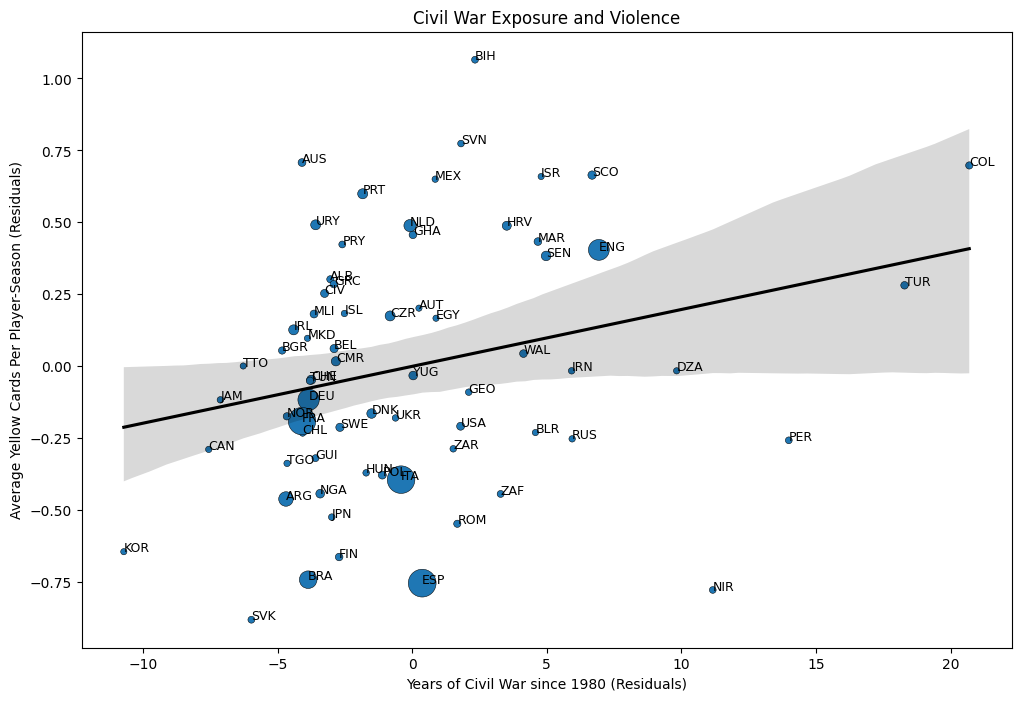

In [31]:
# load data
wb_codes = pd.read_csv("Wb_codes.csv")
wb_codes = wb_codes.rename(columns={"id": "nation"})
wb_codes = wb_codes.sort_values(by="nation")
soccer_data = pd.read_stata("soccer_data.dta")

# drop num_country and missing contract
soccer_data = soccer_data.drop(columns=["num_country"])
soccer_data = soccer_data.dropna(subset=["contract"])

# only keep these leagues
top_leagues = ['italian', 'champions', 'english', 'french', 'german', 'spanish']
soccer_data['league'] = soccer_data[top_leagues].any(axis=1)

# get the number of players per country
league_counts = soccer_data[soccer_data['league']].groupby('nationality')['player_id'].count()
soccer_data['num_country'] = soccer_data['nationality'].map(league_counts)

# merge wb_codes
soccer_data = soccer_data.merge(wb_codes, how="left", on="nation")

# Collapse

collapsed = ['wb_code', 'yellow_card', 'civwar', 'nation', 'num_country', 'age',
             'games_start', 'games_sub', 'goalie', 'defender',
 'forward', 'midfield', 'goals', 'ln_contract', 
 'italian', 'champions', 'english', 'french', 'german', 'spanish',
    'africa', 'asia', 'lac', 'east_europe', 'oecd']

collapse_df = soccer_data[soccer_data['league'] & (soccer_data['num_country'] >= 5)]
collapse_df = collapse_df[collapsed].groupby('wb_code').mean().reset_index()


# regress for yellow_card
vars1 = ['age', 'games_start', 'games_sub', 'defender', 'forward', 'midfield',
           'goals', 'ln_contract', 'italian', 'champions', 'french', 'german', 'spanish',
           'africa', 'asia', 'lac', 'east_europe']
# making the regfression model
X1 = collapse_df[vars1]
X1 = sm.add_constant(X1)
y1 = collapse_df['yellow_card']
model1 = sm.OLS(y1, X1).fit()


collapse_df['yellow_hat'] = model1.fittedvalues
collapse_df['yellow_res'] = collapse_df['yellow_card'] - collapse_df['yellow_hat']


# regress for civwar
# making the regression model
y2 = collapse_df['civwar']
model2 = sm.OLS(y2, X1).fit()


collapse_df['war_hat'] = model2.fittedvalues
collapse_df['war_res'] = collapse_df['civwar'] - collapse_df['war_hat']


# scatterplot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='war_res', y='yellow_res', size='num_country', sizes=(20, 400),
    data=collapse_df, legend=False, marker='o', edgecolor='black'
)
sns.regplot(
    x='war_res', y='yellow_res', data=collapse_df, scatter=False, color='black'
)

# labelinfg points for each country
for i, row in collapse_df.iterrows():
    plt.text(row['war_res'], row['yellow_res'], str(row['wb_code']), fontsize=9)

plt.xlabel("Years of Civil War since 1980 (Residuals)")
plt.ylabel("Average Yellow Cards Per Player-Season (Residuals)")
plt.title("Civil War Exposure and Violence");

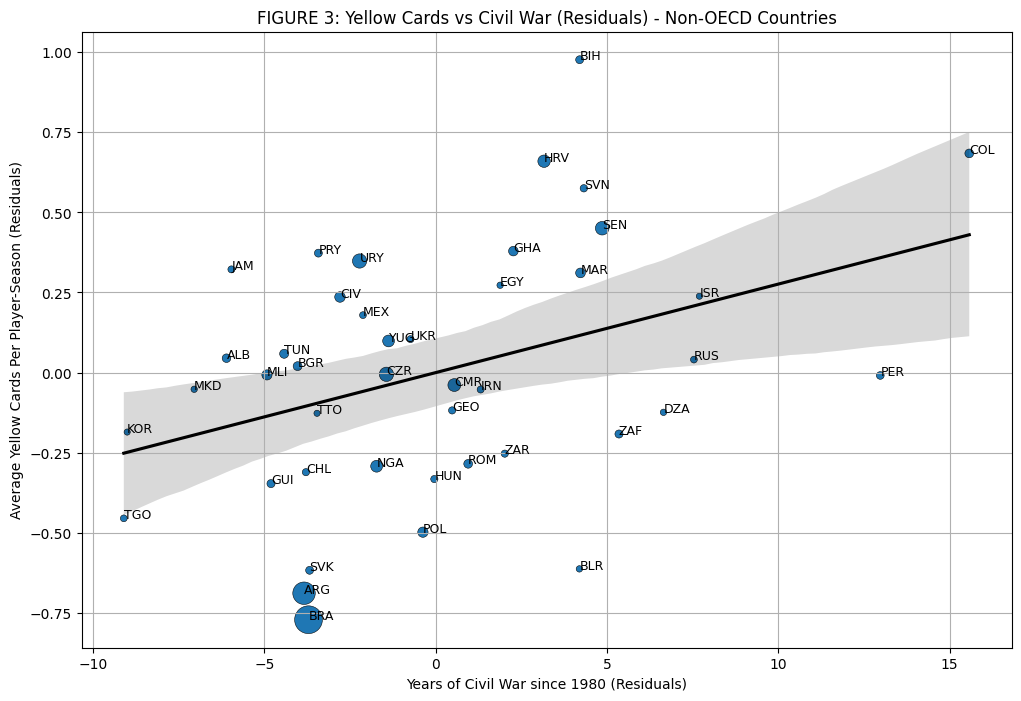

In [32]:
# LOADING DATA
wb_codes = pd.read_csv("Wb_codes.csv")
wb_codes = wb_codes.rename(columns={"id": "nation"})
wb_codes = wb_codes.sort_values(by="nation")
soccer = pd.read_stata("soccer_data.dta")

# CLEANING AND FILTERING DATA
soccer = soccer.dropna(subset=["contract"])

# RELEVANT COUNTRIES: FROM "if (italian | champions |  english  | french | german | spanish)"
country_cols = ['italian', 'champions', 'english', 'french', 'german', 'spanish']
soccer['country_flag'] = soccer[country_cols].any(axis=1)

# PLAYER COUNT BY NATIONALITY
soccer['player_id'] = soccer['player_id'].astype(str)
soccer['num_country'] = soccer.groupby('nationality')['player_id'].transform(
    lambda x: x.count() if soccer.loc[x.index, 'country_flag'].any() else np.nan
)

soccer = soccer[soccer['oecd'] == 0]

soccer = soccer.merge(wb_codes, how="left", on="nation")

# GROUP SELECTED COLUMNS BY wb_code AND AGGREGATE BY MEAN
group_vars = [
    'wb_code', 'nation', 'civwar', 'age', 'games_start', 'games_sub',
    'goalie', 'defender', 'forward', 'midfield', 'goals', 'ln_contract'
] + country_cols + ['africa', 'asia', 'lac', 'east_europe', 'oecd', 'yellow_card', 'num_country']

collapse_df = soccer[soccer['country_flag'] & (soccer['num_country'] >= 5)]
collapse_df = collapse_df[group_vars].groupby('wb_code').mean().reset_index()

# FIRST REGRESSION: BY YELLOW CARD
X1_vars = ['age', 'games_start', 'games_sub', 'defender', 'forward', 'midfield',
           'goals', 'ln_contract', 'italian', 'champions', 'french', 'german', 'spanish',
           'africa', 'asia', 'lac', 'east_europe']
X1 = collapse_df[X1_vars]
X1 = sm.add_constant(X1)
y1 = collapse_df['yellow_card']
model1 = sm.OLS(y1, X1).fit()
collapse_df['yellowhat'] = model1.fittedvalues
collapse_df['yellow_res'] = collapse_df['yellow_card'] - collapse_df['yellowhat']

# SECOND REGRESSION: BY CIVIL WAR 
y2 = collapse_df['civwar']
model2 = sm.OLS(y2, X1).fit()
collapse_df['warhat'] = model2.fittedvalues
collapse_df['war_res'] = collapse_df['civwar'] - collapse_df['warhat']

# PLOTTING
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='war_res', y='yellow_res', size='num_country', sizes=(20, 400),
    data=collapse_df, legend=False, marker='o', edgecolor='black'
)
sns.regplot(
    x='war_res', y='yellow_res', data=collapse_df, scatter=False, color='black'
)

for i, row in collapse_df.iterrows():
    plt.text(row['war_res'], row['yellow_res'], str(row['wb_code']), fontsize=9)

plt.xlabel("Years of Civil War since 1980 (Residuals)")
plt.ylabel("Average Yellow Cards Per Player-Season (Residuals)")
plt.title("FIGURE 3: Yellow Cards vs Civil War (Residuals) - Non-OECD Countries")
plt.grid(True);

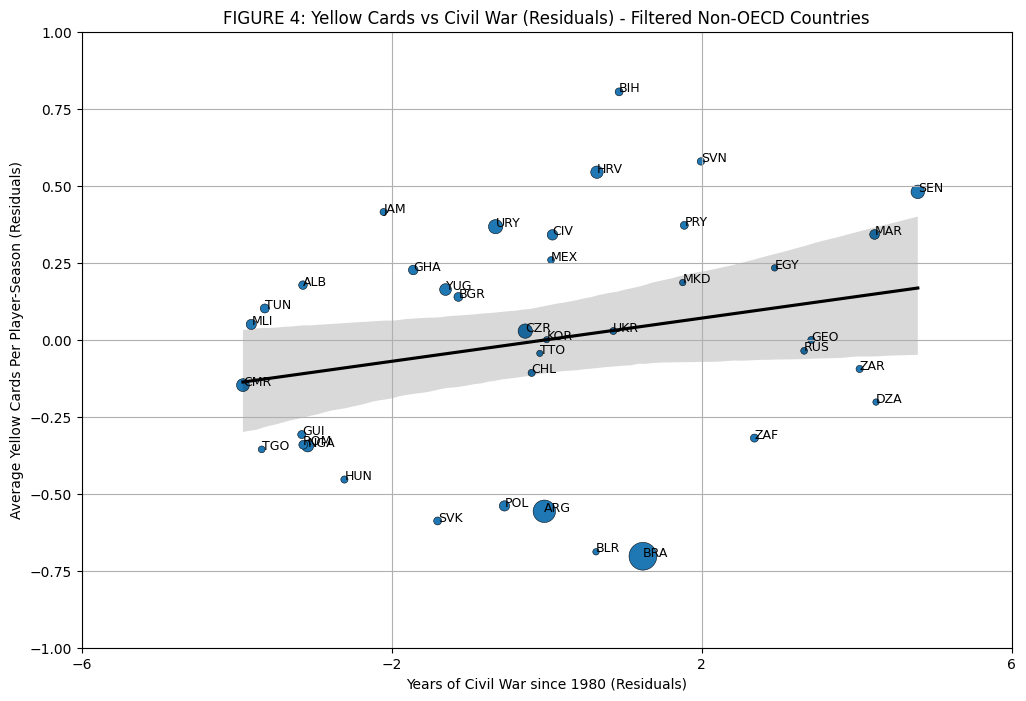

In [33]:
wb_codes = pd.read_csv("Wb_codes.csv")
wb_codes = wb_codes.rename(columns={"id": "nation"})
wb_codes = wb_codes.sort_values(by="nation")

#Load soccer and clean
soccer = pd.read_stata("soccer_data.dta")
soccer = soccer.dropna(subset=["contract"])
soccer['country_flag'] = soccer[['italian', 'champions', 'english', 'french', 'german', 'spanish']].any(axis=1)
soccer['player_id'] = soccer['player_id'].astype(str)
soccer['num_country'] = soccer.groupby('nationality')['player_id'].transform(
    lambda x: x.count() if soccer.loc[x.index, 'country_flag'].any() else np.nan
)
soccer = soccer[soccer['oecd'] == 0]
nations_drop = [23, 52, 54, 78, 101]
soccer = soccer[~soccer['nation'].isin(nations_drop)]

soccer = soccer.merge(wb_codes, how="left", on="nation")

group_vars = [
    'wb_code', 'nation', 'civwar', 'age', 'games_start', 'games_sub',
    'goalie', 'defender', 'forward', 'midfield', 'goals', 'ln_contract'
] + country_cols + ['africa', 'asia', 'lac', 'east_europe', 'oecd', 'yellow_card', 'num_country']

collapse_df = soccer[soccer['country_flag'] & (soccer['num_country'] >= 5)]
collapse_df = collapse_df[group_vars].groupby('wb_code').mean().reset_index()


#Regress
X1_vars = ['age', 'games_start', 'games_sub', 'defender', 'forward', 'midfield',
           'goals', 'ln_contract', 'italian', 'champions', 'french', 'german', 'spanish',
           'africa', 'asia', 'lac', 'east_europe']
X1 = collapse_df[X1_vars]
X1 = sm.add_constant(X1)
y1 = collapse_df['yellow_card']
model1 = sm.OLS(y1, X1).fit()
collapse_df['yellowhat'] = model1.fittedvalues
collapse_df['yellow_res'] = collapse_df['yellow_card'] - collapse_df['yellowhat']

y2 = collapse_df['civwar']
model2 = sm.OLS(y2, X1).fit()
collapse_df['warhat'] = model2.fittedvalues
collapse_df['war_res'] = collapse_df['civwar'] - collapse_df['warhat']

#PLOTTTTT
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='war_res', y='yellow_res', size='num_country', sizes=(20, 400),
    data=collapse_df, legend=False, marker='o', edgecolor='black'
)
sns.regplot(
    x='war_res', y='yellow_res', data=collapse_df, scatter=False, color='black'
)

for _, row in collapse_df.iterrows():
    plt.text(row['war_res'], row['yellow_res'], str(row['wb_code']), fontsize=9)

plt.xlabel("Years of Civil War since 1980 (Residuals)")
plt.ylabel("Average Yellow Cards Per Player-Season (Residuals)")
plt.title("FIGURE 4: Yellow Cards vs Civil War (Residuals) - Filtered Non-OECD Countries")
plt.xticks(np.arange(-6, 7, 4))
plt.yticks(np.arange(-1, 1.25, 0.25))
plt.grid(True)
plt.show()


In [34]:
figure_1a = pd.read_excel('graphs/Figure_1A.xls').dropna()
figure_1a = figure_1a[figure_1a['cause'] != 'Total']
figure_1a

,League,cause,2005-2006,2006-2007,2007-2008,Average,Percent
0,Serie A TIM,Assault,1299,1357.0,1413.0,1356.333333,73.834150
1,Serie A TIM,Unsportsmanlike Conduct,207,320.0,281.0,269.333333,14.661586
2,Serie A TIM,Other Non-Violent,174,235.0,225.0,211.333333,11.504264


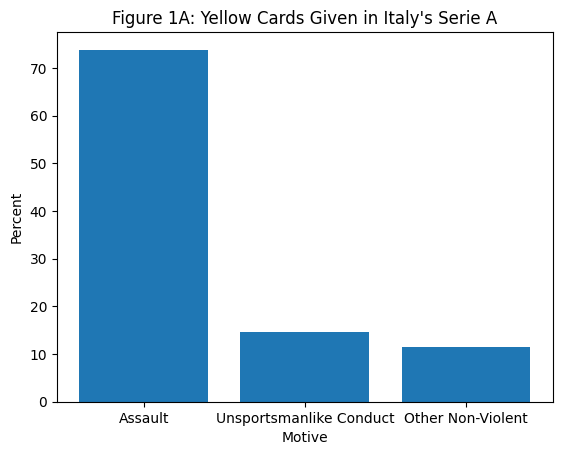

In [35]:
plt.bar(figure_1a['cause'], figure_1a['Percent'])
plt.xlabel('Motive')
plt.ylabel('Percent')
plt.title("Figure 1A: Yellow Cards Given in Italy's Serie A");

In [36]:
figure_1b = pd.read_excel('graphs/Figure_1B.xls')
figure_1b = figure_1b[figure_1b['Motive'] != 'Grand Total']
figure_1b

,Motive,2004-2005,2005-2006,Sum,Percent
0,Violent Foul,446,464,910,64.447592
1,Unsporting Behavior,177,193,370,26.203966
2,Non-Violent Offense,56,76,132,9.348442


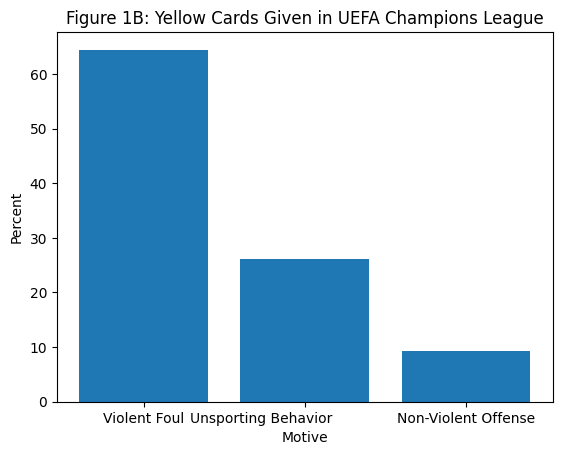

In [37]:
plt.bar(figure_1b['Motive'], figure_1b['Percent'])
plt.xlabel('Motive')
plt.ylabel('Percent')
plt.title("Figure 1B: Yellow Cards Given in UEFA Champions League");

In [38]:
df = pd.read_stata('soccer_data.dta')

x_region = ['africa', 'asia', 'lac', 'east_europe']

labels = {
    'civwar': 'Years of civil war',
    'ln_income': 'Log GNI per capita',
    'r_law': 'Rule of Law',
    'age': 'Age',
    'ln_contract': 'Log transfer fee',
    'games_start': 'Games Started',
    'games_sub': 'Substitute',
    'defender': 'Defender',
    'forward': 'Forward',
    'midfield': 'Midfield',
    'goalie': 'Goalie',
    'goals': 'Goals',
    'champions': 'European Champions League',
    'french': 'French League',
    'german': 'German League',
    'italian': 'Italian League',
    'spanish': 'Spanish League',
    'english': 'English League',
    'war_after': 'Civil war years post-birth',
    'war_before': 'Civil war years pre-birth'
}

df = df.rename(columns=labels)

df = df.dropna(subset=['Log transfer fee'])

mask = (
    (df['Italian League'] | df['European Champions League'] | df['English League'] | 
     df['French League'] | df['German League'] | df['Spanish League']) & 
    (df['num_country'] >= 5)
)

variables = [
    'yellow_card', 'red_card', 'Years of civil war', 'Rule of Law', 'income',
    'Age', 'weekly_wage', 'contract', 'Games Started', 'Substitute',
    'Goalie', 'Defender', 'Forward', 'Midfield', 'Goals'
] + x_region + ['oecd', 'English League', 'European Champions League', 
                'French League', 'German League', 'Italian League', 'Spanish League']

filtered_df = df[mask][variables]

stats = pd.DataFrame({
    'Mean': filtered_df.mean(),
    'Std Dev': filtered_df.std(),
    'Min': filtered_df.min(),
    'Max': filtered_df.max(),
    'N': filtered_df.count()
})

stats = stats.round(3)

table_data = []
for var in stats.index:
    row = [var] + [stats.loc[var, col] for col in stats.columns]
    table_data.append(row)

headers = ['Variable'] + list(stats.columns)
table = SimpleTable(table_data, headers=headers)

print(table)

         Variable             Mean      Std Dev    Min      Max      N  
------------------------------------------------------------------------
              yellow_card       2.434       2.734    0.0       16.0 5035
                 red_card       0.157       0.416    0.0        3.0 5035
       Years of civil war       2.742       4.743    0.0       26.0 5035
              Rule of Law        0.85       0.887  -1.76        2.1 5035
                   income   26203.863   10923.414  720.0    44260.0 4965
                      Age      25.993       4.404   17.0       41.0 5035
              weekly_wage   23991.376   27014.382    0.0   190000.0 5034
                 contract 6323514.796 8198478.045 3000.0 78000000.0 5035
            Games Started        13.8      11.486    0.0       40.0 5035
               Substitute        3.13       3.898    0.0       29.0 5035
                   Goalie       0.077       0.267    0.0        1.0 5035
                 Defender       0.333       0.471  

In [39]:
df = pd.read_stata('soccer_data.dta')

x_region = ['africa', 'asia', 'lac', 'east_europe']

labels = {
    'civwar': 'Years of civil war',
    'ln_income': 'Log GNI per capita',
    'r_law': 'Rule of Law',
    'age': 'Age',
    'ln_contract': 'Log transfer fee',
    'games_start': 'Games Started',
    'games_sub': 'Substitute',
    'defender': 'Defender',
    'forward': 'Forward',
    'midfield': 'Midfield',
    'goalie': 'Goalie',
    'goals': 'Goals',
    'champions': 'European Champions League',
    'french': 'French League',
    'german': 'German League',
    'italian': 'Italian League',
    'spanish': 'Spanish League',
    'english': 'English League',
    'war_after': 'Civil war years post-birth',
    'war_before': 'Civil war years pre-birth'
}

df = df.rename(columns=labels)

mask = (
    (df['Italian League'] | df['European Champions League'] | df['English League'] | 
     df['French League'] | df['German League'] | df['Spanish League']) & 
    (df['num_country'] >= 5)
)

filtered_df = df[mask].copy()

def run_nbreg(y, X, cluster_var='nation'):
    data = pd.concat([filtered_df[y], X, filtered_df[cluster_var]], axis=1)
    data = data.dropna()
    
    X = sm.add_constant(data[X.columns])
    
    model = sm.NegativeBinomial(data[y], X)
    try:
        results = model.fit(cov_type='cluster', cov_kwds={'groups': data[cluster_var]})
    except:
        try:
            results = model.fit(
                method='nm',  
                maxiter=1000,
                cov_type='cluster',
                cov_kwds={'groups': data[cluster_var]}
            )
        except:
            results = model.fit(
                method='nm',
                maxiter=2000,
                start_params=np.zeros(X.shape[1] + 1),  
                cov_type='cluster',
                cov_kwds={'groups': data[cluster_var]}
            )
    
    return results

base_vars = ['Years of civil war', 'Age', 'Games Started', 'Substitute', 
             'Defender', 'Forward', 'Midfield', 'Goals', 'Log transfer fee',
             'Italian League', 'European Champions League', 'French League', 
             'German League', 'Spanish League'] + x_region

# Column 1
X1 = filtered_df[base_vars]
results1 = run_nbreg('yellow_card', X1)

# Column 2
X2 = filtered_df[base_vars + ['Log GNI per capita']]
results2 = run_nbreg('yellow_card', X2)

# Column 3
X3 = filtered_df[base_vars + ['Rule of Law']]
results3 = run_nbreg('yellow_card', X3)

# Column 4
X4 = filtered_df[base_vars + ['Rule of Law']]
results4 = run_nbreg('red_card', X4)

# Column 5
X5 = filtered_df[base_vars + ['Rule of Law']]
X5 = X5.drop('Defender', axis=1)  
X5 = X5.drop('Goals', axis=1)     
X5['Goalie'] = filtered_df['Goalie']  
results5 = run_nbreg('Goals', X5)

# Column 6
X6 = filtered_df[base_vars]
X6 = X6.drop('Years of civil war', axis=1)
X6['Civil war years pre-birth'] = filtered_df['Civil war years pre-birth']
X6['Civil war years post-birth'] = filtered_df['Civil war years post-birth']
results6 = run_nbreg('yellow_card', X6)

# Column 7
X7 = X6.copy()  
results7 = run_nbreg('red_card', X7)

results_list = [results1, results2, results3, results4, results5, results6, results7]

         Current function value: 1.677953
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
         Current function value: 1.676786
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
         Current function value: 1.677921
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/Users/kimchu/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/kimchu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kimchu/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/Users/kimchu/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kimchu/Library/Python/3.9/lib/python/site-packages/scipy/

         Current function value: 0.410769
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
         Current function value: nan
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 15
         Current function value: 1.678003
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
         Current function value: 0.411020
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/Users/kimchu/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/Users/kimchu/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/Users/kimchu/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/Users/kimchu/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/Users/kimchu/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Desired error not necessarily achieved due 

In [40]:
def format_parameter(param, tval):
    """Format parameter with t-statistic in parentheses and stars"""
    stars = ''
    abs_t = abs(tval)
    if abs_t > 2.58:
        stars = '***'
    elif abs_t > 1.96:
        stars = '**'
    elif abs_t > 1.64:
        stars = '*'
    return f"{param:.4f} ({abs_t:.2f}){stars}"

table_data = {}
model_vars = {
    'Country characteristics': ['Years of civil war', 'Civil war years postbirth', 
                              'Civil war years prebirth', 'Log GNI per capita', 'Rule of Law'],
    'Player characteristics': ['Age', 'Log transfer fee', 'Games Started', 'Substitute',
                             'Defender', 'Forward', 'Midfield', 'Goalie', 'Goals'],
    'Soccer leagues': ['European Champions League', 'French League', 'German League',
                      'Italian League', 'Spanish League']
}

for i, results in enumerate(results_list):
    col_name = f"({i+1})"
    params = results.params
    tvalues = results.tvalues
    
    for category, variables in model_vars.items():
        if category not in table_data:
            table_data[category] = {}
            table_data[category][col_name] = ''
            
        for var in variables:
            if var in params:
                key = f"    {var}"  
                if key not in table_data:
                    table_data[key] = {}
                table_data[key][col_name] = format_parameter(params[var], tvalues[var])
            else:
                key = f"    {var}"  
                if key not in table_data:
                    table_data[key] = {}
                table_data[key][col_name] = ''

df_results = pd.DataFrame(table_data).T

obs_row = pd.DataFrame({
    'Observations': [str(r.nobs) for r in results_list]
}, index=['(1)', '(2)', '(3)', '(4)', '(5)', '(6)', '(7)']).T

fixed_effects_row = pd.DataFrame({
    'Regional fixed effects': ['Yes' for _ in results_list]
}, index=['(1)', '(2)', '(3)', '(4)', '(5)', '(6)', '(7)']).T

df_results = pd.concat([df_results, fixed_effects_row, obs_row])

print("\nTable 2. Empirical Results: Civil War\n")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(df_results.to_string(justify='right'))


Table 2. Empirical Results: Civil War

                                             (1)                (2)                (3)                (4)             (5)                (6)                (7)
Country characteristics                                         NaN                NaN                NaN             NaN                NaN                NaN
    Years of civil war          0.0078 (2.68)***    0.0076 (2.46)**   0.0076 (2.58)***     0.0129 (1.95)*   -0.0005 (nan)                                      
    Civil war years postbirth                                                                                                                                  
    Civil war years prebirth                                                                                                                                   
    Log GNI per capita                                0.0322 (0.70)                                                                                            
